# Burkina/Sorghum example

The aim of this notebook is to show how to use the SARRA-Py package to prepare data and perform atteinable yield simulations for sorghum in Burkina Faso. Also, we aim to compare results with MAPSPAM 2017.

# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time

# Extract exemple data

In [2]:
import zipfile

path_to_zip_file = "../data/exemple_data/exemple_data_burkina_2017.zip"
directory_to_extract_to = "../data/exemple_data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


# Parameters

In [2]:
# date at which simulation is started, and simulation length (duration)
date_start = datetime.date(2017,4,1)
duration = 200

# path of gridded rainfall datasets
TAMSAT_path = "../data/exemple_data/TAMSAT_v3.1_burkina_rfe_filled/"
# CHIRPS_path = "/mnt/d/Mes Donnees/SARRA_data-download/data/3_output/CHIRPS_v2.0_Africa_burkina"

# path for gridded weather datasets
AgERA5_data_path = "../data/exemple_data/AgERA5_burkina/"

# parameter file names
file_paramVariete = "sorgho_variety.yaml"
file_paramITK = "sorghum_burkina_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# data exported from SARRA-H, only used for comparison purposes
file_df_weather = "Meteorologie_US0001.txt"
file_df_rain = "Pluviometrie_US0001.txt"
file_df_ET0 = "ET0_US0001.txt"
file_df_irrig = "Irrigation_AG3US20124.txt"

# Loading base data

This is data that won't change along the simulation.

In [3]:
# define grid dimensions from the rainfall dataset
grid_width, grid_height = get_grid_size(TAMSAT_path, date_start, duration)

# initialize empty xarray dataset
data = xr.Dataset()

# load rainfall and weather data
data = load_TAMSAT_data(data, TAMSAT_path, date_start, duration)
data = load_AgERA5_data(data, AgERA5_data_path, date_start, duration)

# compute day length raster
data = calc_day_length_raster(data, date_start, duration)

# load soil parameters
data = load_iSDA_soil_data(data, grid_width, grid_height)

100%|██████████| 200/200 [00:22<00:00,  8.75it/s]


# Load simulation data

Loading and preparing simulation-specific data
Loading main input dataarrays

In [4]:
# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

# initialize null irrigation scheme
data = initialize_default_irrigation(data)

In [5]:
data

<xarray.Dataset>
Dimensions:        (x: 239, y: 186, time: 200)
Coordinates:
  * x              (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y              (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref    int64 0
Dimensions without coordinates: time
Data variables: (12/14)
    rain           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tpMoy          (time, y, x) float32 nan nan nan nan ... 26.34 26.34 26.49
    ET0            (time, y, x) float32 nan nan nan nan ... 3.171 3.171 3.205
    rg             (time, y, x) float32 nan nan nan nan ... 21.69 21.69 21.92
    dureeDuJour    (time, y, x) float32 12.29 12.29 12.29 ... 11.9 11.9 11.9
    soil_type      (y, x) float64 11.0 11.0 9.0 9.0 11.0 ... 9.0 9.0 9.0 9.0 9.0
    ...             ...
    stockIniProf   (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stockIniSurf   (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    seuilRuiss     (y, x) float32 20.0 20.0 18.0 18.0 ... 18.0 18.0 18.0 18.0
    pourcRuiss     (y, x) float32 0.27 0.27 0.32 0.32 ... 0.32 0.32 0.32 0.32
    ru             (y, x) float32 130.0 130.0 155.0 155.0 ... 155.0 155.0 155.0
    irrigation     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

# Run

In [6]:
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)

In [8]:
start_time = time.time()
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)
print("--- %s seconds, %s second per iter ---" % ((time.time() - start_time), (time.time() - start_time)/duration))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'EvalPhenoSarrahV3':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../src/sarra_py/models.py", line 32:[0m
[1mdef run_model(paramVariete, paramITK, paramTypeSol, data, duration):
    <source elided>
        # updating phenological stages
[1m        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete)
[0m        [1m^[0m[0m
[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 1: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 2: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 3: [1mCannot determine Numba type of <class 'xarray.core.dataset.Dataset'>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 1: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 2: [1mCannot determine Numba type of <class 'dict'>[0m
- argument 3: [1mCannot determine Numba type of <class 'xarray.core.dataset.Dataset'>[0m


## Mapping results

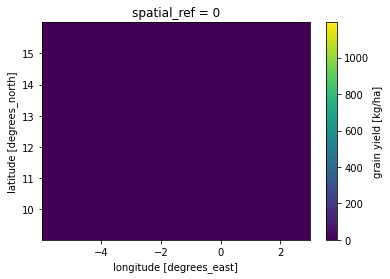

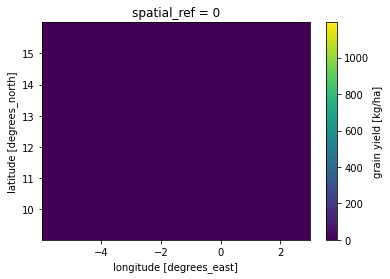

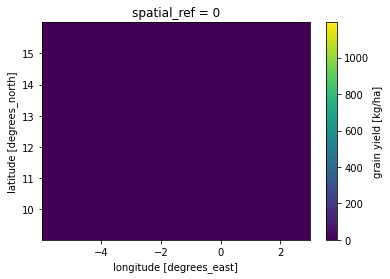

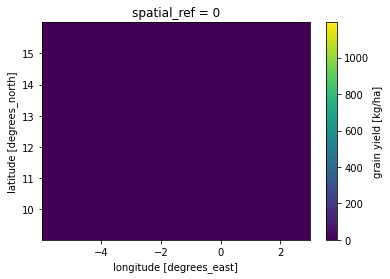

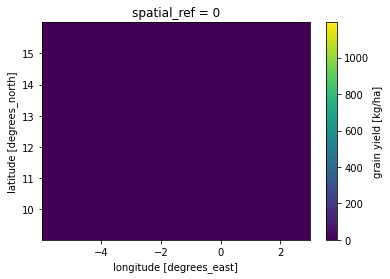

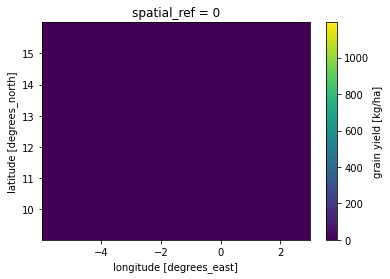

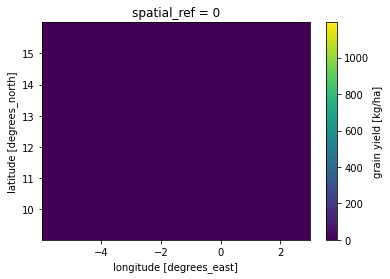

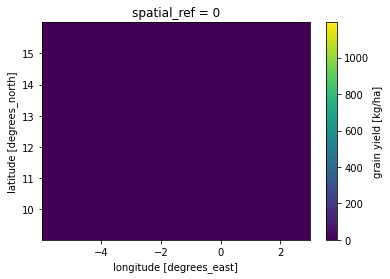

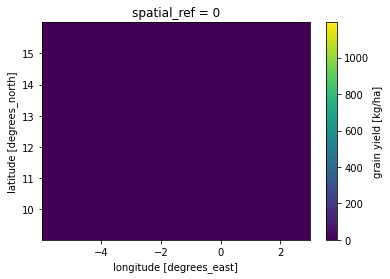

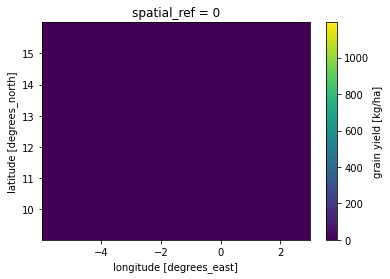

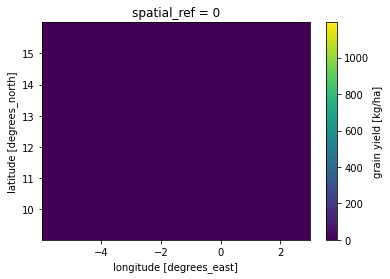

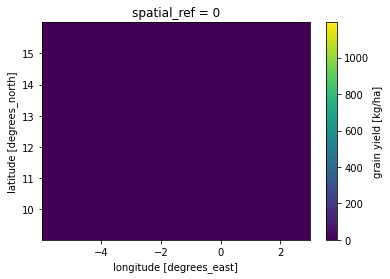

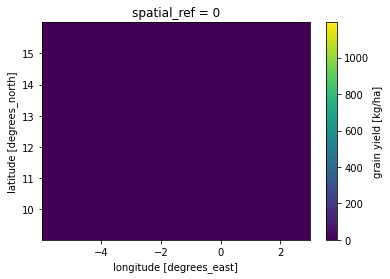

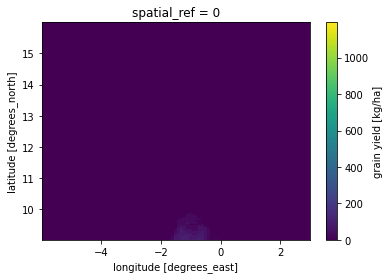

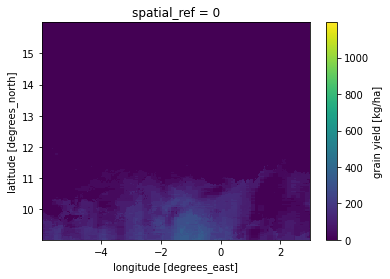

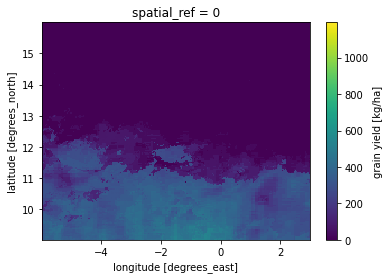

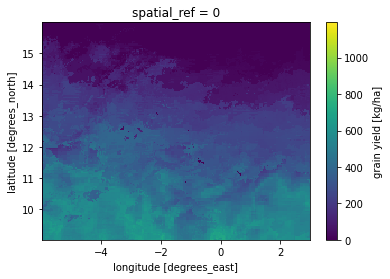

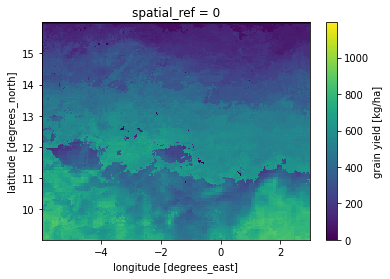

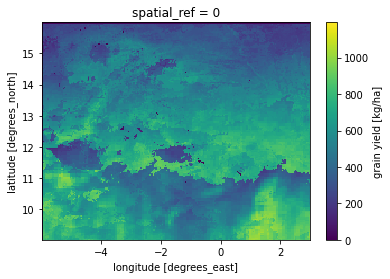

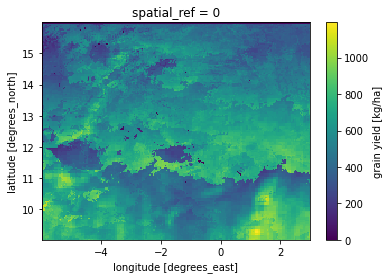

In [9]:
variable = "rdt"
vmax = data[variable].max().values
for i in range(20):
    data[variable][9*i,:,:].plot(vmin=0, vmax=vmax)
    plt.show()

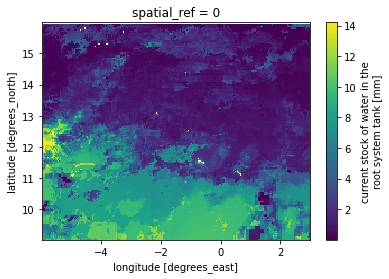

In [10]:
data["root_tank_stock"][-1,:,:].plot()

## Loading MAPSPAM 2017 data

In [11]:
# file was gathered from https://dataverse.harvard.edu/file.xhtml?fileId=4271678&version=3.0
# rainfed high inputs production (H)
# load image into a xarray dataarray
mapspam_data = xr.open_dataarray("../data/exemple_data/MapSPAM/spam2017V2r1_SSA_Y_SORG_H.tif")

In [12]:
# reproject the dataarray to the same projection and resolution as the simulation
mapspam_data = mapspam_data.rio.reproject_match(data["rdt"])

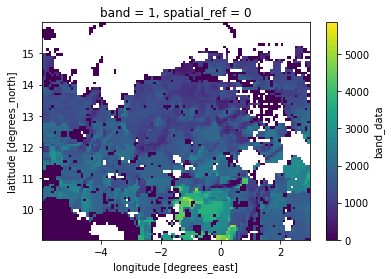

In [13]:
mapspam_data.plot()

In [15]:
# do a scatterplot of the values of the data["rdt"] against mapspam_data using plotly express
# remove the null values from the two datasets
# add a trendline to the scatterplot
import plotly.express as px
df = pd.DataFrame({"rdt":data["rdt"][-1,:,:].values.flatten(), "mapspam":mapspam_data.values.flatten()})
df = df[df["rdt"]>0]
df = df[df["mapspam"]>0]
fig = px.scatter(df, x="rdt", y="mapspam", trendline="ols")
fig.show()



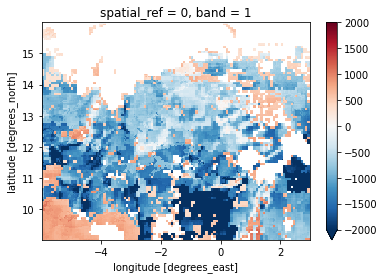

In [16]:
# compute the difference between the two datasets and plot the map
diff = data["rdt"][-1,:,:] - mapspam_data
diff.plot(cmap="RdBu_r", vmin=-2000, vmax=2000)
plt.rcParams['figure.figsize'] = [8,6]
plt.show()


/home/jeremy/.pyenv/versions/3.9.6/envs/venv_SARRA_Py/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning:

divide by zero encountered in log



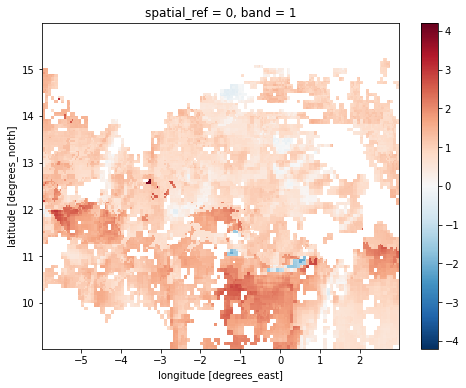

In [17]:
# compute the difference between the two datasets and plot the map
diff = -np.log(data["rdt"][-1,:,:] / mapspam_data)
diff.plot(cmap="RdBu_r")
plt.rcParams['figure.figsize'] = [8,6]
plt.show()